In [1]:
import os
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from numpy.linalg import norm
from memory_profiler import memory_usage
from sklearn.decomposition import IncrementalPCA

# --- File paths ---
base_path = r'G:\My Drive\NUS\NUS Y6S1\ME5311\PROJECT_2420_ME5311'
slp_path = os.path.join(base_path, 'slp.nc')
t2m_path = os.path.join(base_path, 't2m.nc')

# --- Load datasets ---
ds_slp = xr.open_dataset(slp_path)
ds_t2m = xr.open_dataset(t2m_path)

slp = ds_slp['msl'].values
t2m = ds_t2m['t2m'].values
timestamps = ds_slp['time'].values
lats = ds_slp['latitude'].values
longs = ds_slp['longitude'].values

# --- Reshape and center SLP ---
n_time, n_lat, n_lon = slp.shape
A_slp = slp.reshape(n_time, -1).T
A_mean_slp = A_slp.mean(axis=1, keepdims=True)
A_centered_slp = A_slp - A_mean_slp

In [2]:
# --- Define Streaming SVD function with monitoring ---
def perform_streaming_svd_with_monitoring(A, n_components=1000, batch_size=1000):
    """Performs streaming SVD with IncrementalPCA with runtime and memory tracking"""
    print("Performing Streaming SVD (IncrementalPCA) on SLP data...")

    def streaming_svd_task():
        global ipca, U_stream, S_stream, VT_stream

        # Transpose A to have samples as rows
        A_T = A.T
        n_samples = A_T.shape[0]
        n_features = A_T.shape[1]

        # Ensure n_components does not exceed batch size or feature dimension
        safe_n_components = min(n_components, batch_size, n_features)

        # Initialize IncrementalPCA
        ipca = IncrementalPCA(n_components=safe_n_components)

        # Process in batches (streaming)
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            ipca.partial_fit(A_T[i:end_idx])
            print(f"Processed batch {i//batch_size + 1}/{(n_samples-1)//batch_size + 1}")

        # Extract components from the fitted model
        VT_stream = ipca.components_
        S_stream = np.sqrt(ipca.explained_variance_ * (n_samples - 1))

        # Calculate U = A * V * S^-1
        V = VT_stream.T
        S_inv = np.diag(1.0 / S_stream)
        U_stream = A.T @ V @ S_inv

    # Monitor runtime and memory usage
    start = time.time()
    mem_usage = memory_usage(streaming_svd_task, max_usage=True)
    elapsed = time.time() - start

    return elapsed, mem_usage

# --- Set parameters and run Streaming SVD with performance monitoring ---
batch_size = 100  # Set based on memory constraints
n_components = 1000  # Initial request (will be adjusted internally)

elapsed_stream, peak_mem_stream = perform_streaming_svd_with_monitoring(
    A_centered_slp, n_components=n_components, batch_size=batch_size
)

# --- SVD result shapes (informational) ---
print(f"A shape: {A_slp.shape}")
print(f"U shape: {U_stream.shape}, S shape: {S_stream.shape}, VT shape: {VT_stream.shape}")


Performing Streaming SVD (IncrementalPCA) on SLP data...
Processed batch 1/161
Processed batch 2/161
Processed batch 3/161
Processed batch 4/161
Processed batch 5/161
Processed batch 6/161
Processed batch 7/161
Processed batch 8/161
Processed batch 9/161
Processed batch 10/161
Processed batch 11/161
Processed batch 12/161
Processed batch 13/161
Processed batch 14/161
Processed batch 15/161
Processed batch 16/161
Processed batch 17/161
Processed batch 18/161
Processed batch 19/161
Processed batch 20/161
Processed batch 21/161
Processed batch 22/161
Processed batch 23/161
Processed batch 24/161
Processed batch 25/161
Processed batch 26/161
Processed batch 27/161
Processed batch 28/161
Processed batch 29/161
Processed batch 30/161
Processed batch 31/161
Processed batch 32/161
Processed batch 33/161
Processed batch 34/161
Processed batch 35/161
Processed batch 36/161
Processed batch 37/161
Processed batch 38/161
Processed batch 39/161
Processed batch 40/161
Processed batch 41/161
Processed

In [11]:
# --- Accuracy (Reconstruction Error) ---
def calculate_reconstruction_error(U, S, VT, A_original, A_mean):
    """Calculate reconstruction error using Frobenius norm"""
    print(f"U shape: {U.shape}, S shape: {S.shape}, VT shape: {VT.shape}")
    print(f"A_original shape: {A_original.shape}, A_mean shape: {A_mean.shape}")
    
    S_diag = np.diag(S)
    A_reconstructed = U @ S_diag @ VT + A_mean.T  # shape: (16071, 16261)

    # Compare to A_original.T for shape match
    print(f"A_reconstructed shape: {A_reconstructed.shape}")
    error = norm(A_original.T - A_reconstructed) / norm(A_original.T)
    return error, A_reconstructed


# --- Noise Robustness Test ---
def test_noise_robustness(A_T, A_original, A_mean, k, batch_size, noise_scale=0.01):
    np.random.seed(0)
    noise = np.random.normal(scale=noise_scale, size=A_T.shape)
    A_noisy_T = A_T + noise
    
    ipca_noisy = IncrementalPCA(n_components=k, batch_size=batch_size)
    ipca_noisy.fit(A_noisy_T)
    
    VT_noisy = ipca_noisy.components_
    S_noisy = np.sqrt(ipca_noisy.explained_variance_ * (A_T.shape[0] - 1))
    
    # Get U directly
    U_noisy = np.zeros((A_T.shape[0], k))  # Corrected: match sample count
    for i in range(k):
        U_noisy[:, i] = A_T @ VT_noisy[i, :] / S_noisy[i]

    
    S_noisy_diag = np.diag(S_noisy)
    A_reconstructed_noisy = U_noisy @ S_noisy_diag @ VT_noisy + A_mean.T
    error = norm(A_original.T - A_reconstructed_noisy) / norm(A_original.T)
    return error


# Ensure variables are correctly set
A_slp_T = A_centered_slp.T
A_slp = A_centered_slp  # Assuming A_centered_slp is mean-centered input
A_mean_slp = np.mean(A_slp, axis=1, keepdims=True)

# Use results from streaming SVD
U_slp = U_stream
S_slp = S_stream
VT_slp = VT_stream
k = S_slp.shape[0]

# Calculate reconstruction error
reconstruction_error, A_reconstructed = calculate_reconstruction_error(
    U_slp, S_slp, VT_slp, A_slp, A_mean_slp
)

# Test noise robustness
noise_error = test_noise_robustness(
    A_slp_T, A_slp, A_mean_slp, k, batch_size
)

print(f"Reconstruction Error: {reconstruction_error:.6f}")
print(f"Noise Robustness Error: {noise_error:.6f}")


U shape: (16071, 100), S shape: (100,), VT shape: (100, 16261)
A_original shape: (16261, 16071), A_mean shape: (16261, 1)
A_reconstructed shape: (16071, 16261)
Reconstruction Error: 0.078473
Noise Robustness Error: 0.078473



===== Streaming SVD Results for SLP =====
Number of singular values/vectors retained: k = 100
Batch size: 100
Runtime: 50.27 seconds
Peak memory usage: 5321.19 MiB
Reconstruction error (Frobenius norm): 7.847271e-02
Noise robustness (error with Gaussian noise): 7.847270e-02
Energy captured by 100 components: 1.000000 (100.00%)


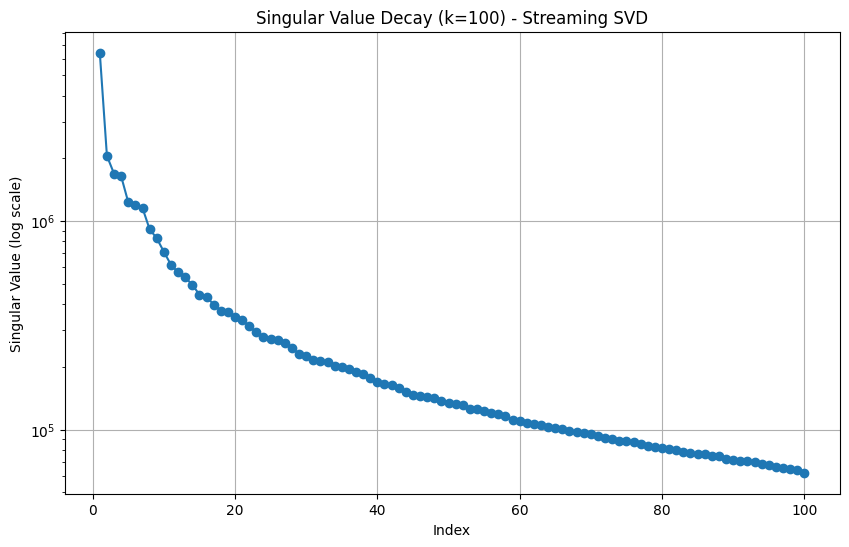

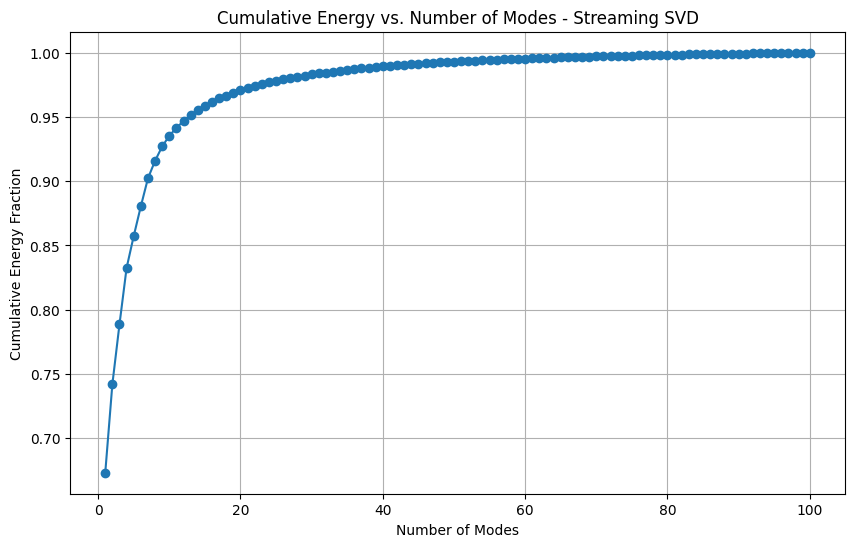

In [12]:
# --- Report results ---
print("\n===== Streaming SVD Results for SLP =====")
print(f"Number of singular values/vectors retained: k = {k}")
print(f"Batch size: {batch_size}")
print(f"Runtime: {elapsed_stream:.2f} seconds")
print(f"Peak memory usage: {peak_mem_stream:.2f} MiB")
print(f"Reconstruction error (Frobenius norm): {reconstruction_error:.6e}")
print(f"Noise robustness (error with Gaussian noise): {noise_error:.6e}")

# --- Cumulative energy (estimated) ---
total_energy = np.sum(S_slp**2)
cumulative_energy = np.cumsum(S_slp**2) / total_energy

print(f"Energy captured by {k} components: {cumulative_energy[-1]:.6f} ({cumulative_energy[-1]*100:.2f}%)")

# --- Optional: Save results to file for later comparison ---
results = {
    "method": "Streaming SVD (IncrementalPCA)",
    "k_value": k,
    "batch_size": batch_size,
    "runtime": elapsed_stream,
    "memory_usage": peak_mem_stream,
    "reconstruction_error": float(reconstruction_error),
    "noise_robustness": float(noise_error),
    "energy_captured": float(cumulative_energy[-1]),
    "top_singular_values": S_slp[:10].tolist()
}

# Save as JSON (optional)
import json
with open("streaming_svd_results.json", "w") as f:
    json.dump(results, f, indent=4)

# --- Plot singular value decay ---
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(S_slp) + 1), S_slp, 'o-')
plt.title(f'Singular Value Decay (k={k}) - Streaming SVD')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True)
plt.savefig('streaming_svd_singular_values.png', dpi=300)
plt.show()

# --- Plot cumulative energy ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(S_slp) + 1), cumulative_energy, 'o-')
plt.title('Cumulative Energy vs. Number of Modes - Streaming SVD')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Energy Fraction')
plt.grid(True)
plt.savefig('streaming_svd_cumulative_energy.png', dpi=300)
plt.show()
